In [2]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

In [16]:
data_csv = pd.read_csv("data\\labeled_data.csv")
data_csv.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
tweets_list = data_csv['tweet'].tolist()
labels_list = data_csv['class'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [ ]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

In [22]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [23]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [24]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [25]:
embedding_vecor_length = 200
class_count = Y.shape[1]

model = Sequential()
model.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],input_shape=(max_wordNum,),trainable=True, name='Embedding'))
model.add(LSTM(100,return_sequences=False,name='LSTM'))
model.add(Dense(20,activation='relu',name='Hidden_Layer_1'))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 52, 200)           8607200   
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               120400    
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 8,729,683
Trainable params: 8,729,683
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train,y_train,
                    validation_data=[X_valid,y_valid],
                    epochs=50, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 12397 samples, validate on 6190 samples
Epoch 1/50
12397/12397 [==============================] - 44s 4ms/step - loss: 0.6772 - acc: 0.7703 - val_loss: 0.5124 - val_acc: 0.7698
Epoch 2/50
12397/12397 [==============================] - 40s 3ms/step - loss: 0.4835 - acc: 0.8457 - val_loss: 0.5275 - val_acc: 0.8485
Epoch 3/50
12397/12397 [==============================] - 40s 3ms/step - loss: 0.4432 - acc: 0.8767 - val_loss: 0.5588 - val_acc: 0.8378
Epoch 4/50
12397/12397 [==============================] - 41s 3ms/step - loss: 0.4161 - acc: 0.8851 - val_loss: 0.4031 - val_acc: 0.8738
Epoch 5/50
12397/12397 [==============================] - 41s 3ms/step - loss: 0.3554 - acc: 0.8942 - val_loss: 0.3510 - val_acc: 0.8858
Epoch 6/50
12397/12397 [==============================] - 49s 4ms/step - loss: 0.3064 - acc: 0.8980 - val_loss: 0.3458 - val_acc: 0.8869
Epoch 7/50
12397/12397 [==============================] - 49s 4ms/step - loss: 0.2547 - acc: 0.9176 - val_loss: 0.3493 - val_acc:

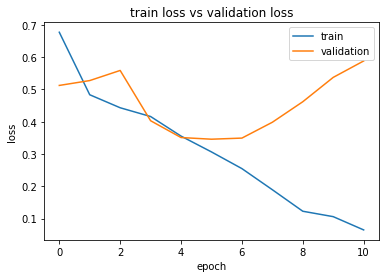

In [27]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6086507039427218
Test accuracy: 0.8318269851901903
